# Titanic Dataset - Your first teacher

In [44]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import data

In [2]:
# read data
df = pd.read_csv('train.csv')


# separate columns to Target, Num, Cat and Unused
TARGET_VAR = 'Survived'
NUM_FEAT = ['Age', 'SibSp', 'Parch', 'Fare']
CAT_FEAT = ['Pclass', 'Sex', 'Embarked']
UNUSED = ['Name', 'Cabin', 'Ticket']

# Concerns:
# Age - some null values may need mean imputation --> can we impute within classes for better accuracy???
# Cabin - many nulls, but surely is important let's see what we can do 

# datatypes
for cat in CAT_FEAT:
    df[cat] = df[cat].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


### grouping of features

Index
* PassengerId - just an index

Target Variable
* Survived - 0 = died, 1 = survived

Physical Features (Estimated impact S,M,L)
* Name (-) - not used to train model
* Sex (L)
* Age (L)
* SibSp (M)
* Parch (M)

Titanic Features
* Pclass (L)
* Ticket (-) - not used to train model (ticket number should not impact)
* Fare (S)
* Cabin (-) - not used to train model (only 204/891 data available, can't impute accurately)
* Embarked (S)

In [3]:
display(df[NUM_FEAT].describe())
display(df[CAT_FEAT].describe(include='all'))

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


,Pclass,Sex,Embarked
count,891,891,889
unique,3,2,3
top,3,male,S
freq,491,577,644


## EDA

0    549
1    342
Name: Survived, dtype: int64

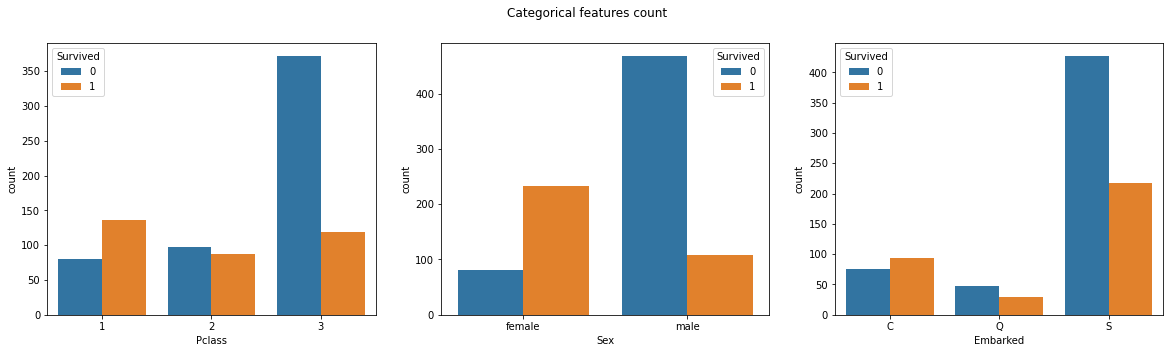

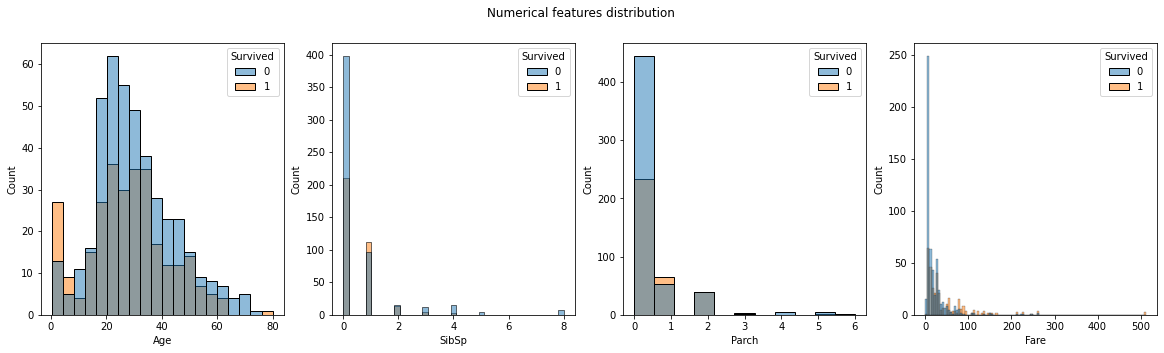

In [4]:
def examine_df(df):
    '''
    Examines the df
    - count instances of each target variable
    - count instances of each target variable with respect to categorical features
    - plot histograms of numerical features
    '''
    # count target var
    display(df[TARGET_VAR].value_counts())

    # cat features
    fig, ax = plt.subplots(1,len(CAT_FEAT),figsize=(20,5))
    for i in range(len(CAT_FEAT)):
        sns.countplot(ax=ax[i], data=df, x=CAT_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Categorical features count')
    plt.show()

    # num feat
    fig, ax = plt.subplots(1,len(NUM_FEAT),figsize=(20,5))
    for i in range(len(NUM_FEAT)):
        sns.histplot(ax=ax[i], data=df, x=NUM_FEAT[i], hue=TARGET_VAR)
    fig.suptitle('Numerical features distribution')
    plt.show()

examine_df(df)
# PClass - first class got > 0.5 survival rate, 3rd class died way more
# Sex - male died more
# Embarked - most were out of S port
# All except age are kind of exponentially distributed
# Age is kind of a skewed normal


## Cleaning

Deal with missing values
* Numerical --> Median imputation
* Categorical --> replace with mode

In [5]:
# numerical
print('Age - Before')
display(df['Age'].describe())

print('\nAge - After')
df['Age'].fillna(df['Age'].median(), inplace=True) #impute with median because data is a bit skewed
display(df['Age'].describe())

Age - Before


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Age - After


count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [6]:
# cat
print('Embarked - Before')
display(df['Embarked'].describe())

print('\nEmbarked - After')
df['Embarked'].fillna(df['Embarked'].value_counts().sort_values(ascending=False).index[0], inplace=True) # impute with mode
display(df['Embarked'].describe())

Embarked - Before


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object


Embarked - After


count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

In [7]:
# train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=69)

# separate features and target variables
X_train, y_train = df_train.drop([TARGET_VAR], axis=1), df_train[TARGET_VAR]
X_test, y_test = df_test.drop([TARGET_VAR], axis=1), df_test[TARGET_VAR]

0    490
1    311
Name: Survived, dtype: int64

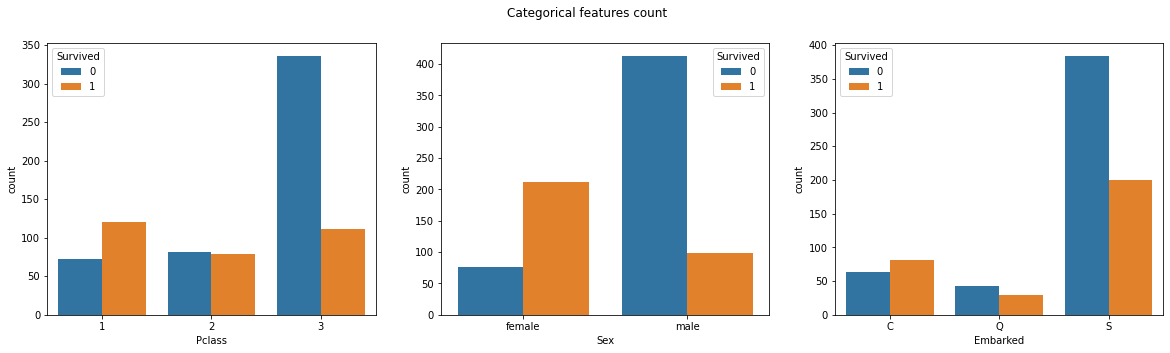

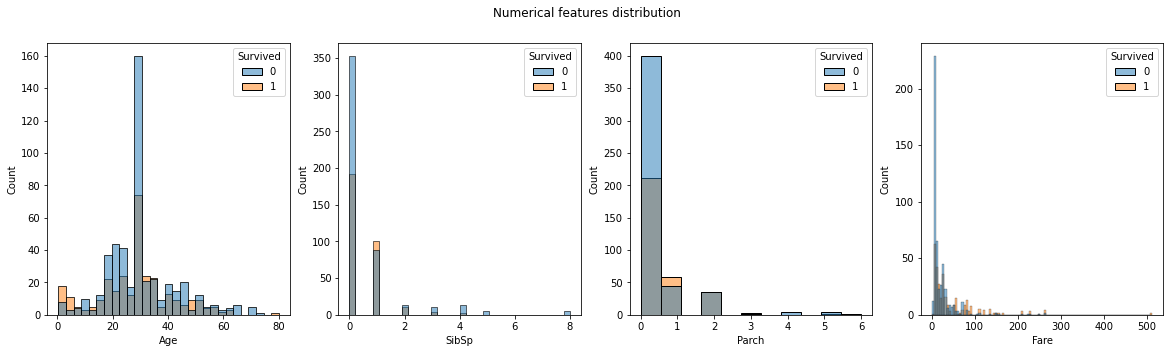

0    59
1    31
Name: Survived, dtype: int64

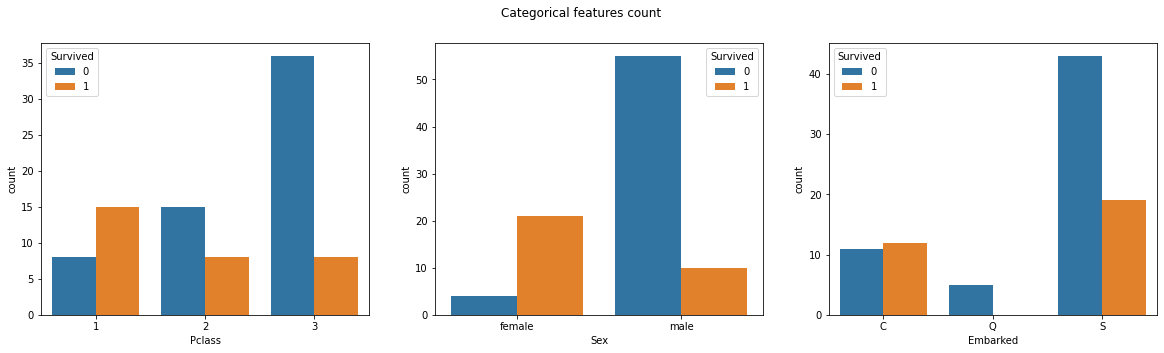

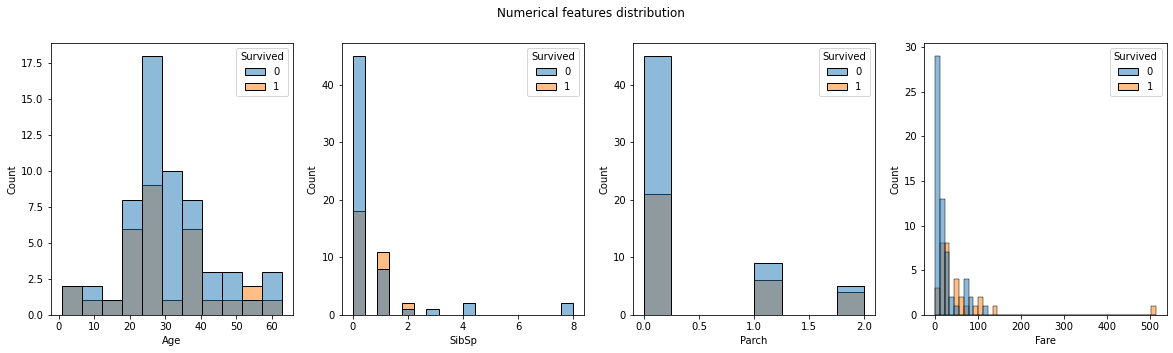

In [8]:
# check training data 
examine_df(df_train)
examine_df(df_test)

## Create function for classifier evaluation

performance metrics
* accuracy
* confusion matrix - precision, recall, f1
* ROC&AUC
* logloss 

what does each metric tell us and what should we care the most????
https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html

DUMB MODEL = saying that all are dead will get an accuracy of ~66% (59/90 ppl died in the test set)

In [9]:
# import metrics
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve, log_loss

def evaluate_cf(cf, X_train, y_train, X_test, y_test):
    # evaluates a classifier with a range of metrics
    
    # fit and predict
    cf.fit(X_train, y_train)
    y_pred = cf.predict(X_test)

    # metrics
    print('Accuracy = {}'.format(accuracy_score(y_test, y_pred)))
    print('Logloss = {}'.format(log_loss(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(cf, X_test, y_test)
    plot_roc_curve(cf, X_test, y_test)


## Construct a pipeline

df --> df_train, df_test --> separate num, cat --> preprocess num, cat separately --> union feature

Accuracy = 0.8444444444444444
Logloss = 5.372751856814786
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        59
           1       0.79      0.74      0.77        31

    accuracy                           0.84        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.84      0.84      0.84        90



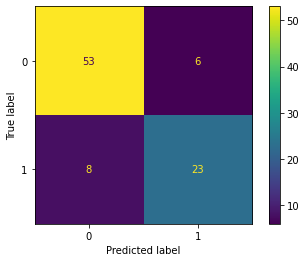

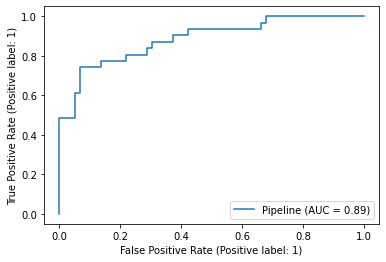

In [65]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# function to get only numerical data from X
get_num_feat = FunctionTransformer(lambda X: X[NUM_FEAT])
# function to get all features from X that will be put into the model
get_cat_feat = FunctionTransformer(lambda X: X[CAT_FEAT])

# function to get one-hot encoding for CAT_FEAT
onehot_cat_feat = FunctionTransformer(lambda X: pd.get_dummies(X))

# create pipeline
num_pl = Pipeline(
                    [
                        ('get_num_feat', get_num_feat), 
                        ('standard_scaler', StandardScaler())
                    ]
                )
cat_pl = Pipeline(
                    [
                        ('get_cat_feat', get_cat_feat), 
                        ('onehot_cat_feat', onehot_cat_feat)
                    ]
                )
pl = Pipeline(   
                [   
                    ('union', FeatureUnion([('num',num_pl), ('cat',cat_pl)])),
                    ('classifier', 
                    # RandomForestClassifier())
                    LogisticRegression(random_state=69))
                ]
            )

# evaluate_cf
evaluate_cf(pl, X_train, y_train, X_test, y_test)

### Hyperparameter tuning
* we can specify the clf in the pipeline to be anything and replace the tuning with other clfs also
* useful kaggle nb for LogisticRegression tuning [Link](https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression)

In [40]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [50]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [69]:
from sklearn.model_selection import GridSearchCV
# specify parameter grid
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=69)],
        'classifier__C': [1]+list(np.logspace(-2,4,10)) # higher C --> tendency to overfit
    }
    ,
    {
        'classifier': [RandomForestClassifier()],
        'classifier__min_samples_leaf': [1,5,10],
        'classifier__max_depth': [None,5,10,20]
    }
]
# fit the GridSearchCV obj
grid_search = GridSearchCV(pl, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
# look at the best score and the results
print('Best cv score = {}'.format(grid_search.best_score_))
print('Best param = {}'.format(grid_search.best_params_))
# print('Best param = {}'.format(grid_search.cv_results_))
print()
print('Params: {}'.format(grid_search.cv_results_['params']))
print('Mean cv score: {}'.format(grid_search.cv_results_['mean_test_score']))
print('Rank: {}'.format(grid_search.cv_results_['rank_test_score']))

Best cv score = 0.8202247191011236
Best param = {'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=5), 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5}

Params: [{'classifier': LogisticRegression(random_state=69), 'classifier__C': 1}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 0.01}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 0.046415888336127774}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 0.21544346900318834}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 1.0}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 4.6415888336127775}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 21.54434690031882}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 100.0}, {'classifier': LogisticRegression(random_state=69), 'classifier__C': 464.1588833612773}, {'classifier': LogisticRegression(random_state=69), 'cl

Accuracy = 0.8333333333333334
Logloss = 5.756498270148678
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        59
           1       0.83      0.65      0.73        31

    accuracy                           0.83        90
   macro avg       0.83      0.79      0.80        90
weighted avg       0.83      0.83      0.83        90



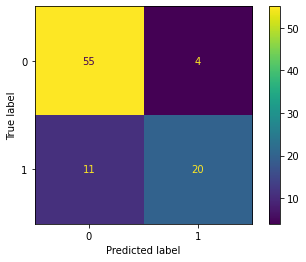

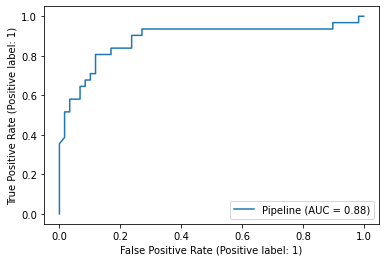

In [75]:
# accuracy on this test set may be lower, but it's cv score is better
best_pl = grid_search.best_estimator_
evaluate_cf(best_pl, X_train, y_train, X_test, y_test)

In [76]:
from sklearn.model_selection import cross_val_score

# base model
print(cross_val_score(pl, df.drop([TARGET_VAR], axis=1), df[TARGET_VAR], cv=3))
# model from grid search
print(cross_val_score(best_pl, df.drop([TARGET_VAR], axis=1), df[TARGET_VAR], cv=3))

[0.7979798  0.78114478 0.79461279]
[0.80808081 0.82491582 0.80808081]
